In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("drive/MyDrive/project/nlp")

Mounted at /content/drive


In [ ]:
! pip install SpeechRecognition
! pip install -U yt-dlp

In [ ]:
def download(url, fname):
    """
    download wav file from `url` as `fname`
    """
    os.system(f"yt-dlp -P ./data -o '{fname}.%(ext)s' -x --audio-format wav {url}")

In [ ]:
url_short_clean = "https://www.youtube.com/watch?v=_nAov8LnFS4&list=PLalDxVXf3NHdC-GsbCQVeTQiCo2Y85F17&index=4&ab_channel=JoongheonKim"
url_long_noisy = "https://www.youtube.com/watch?v=M27xbxCtK6c&list=PLKs7xpqpX1beJ5-EOFDXTVckBQFFyTxUH&index=2&ab_channel=SNUCML"

In [ ]:
download(url_short_clean, "short_clean")
download(url_short_clean, "long_noisy")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tqdm import tqdm
from time import time

In [ ]:
freq, data = wavfile.read('data/short_clean.wav')
data = data[:, 0]

data.shape

(93890106,)

In [ ]:
sec = data.shape[0] / freq
sec

1956.043875

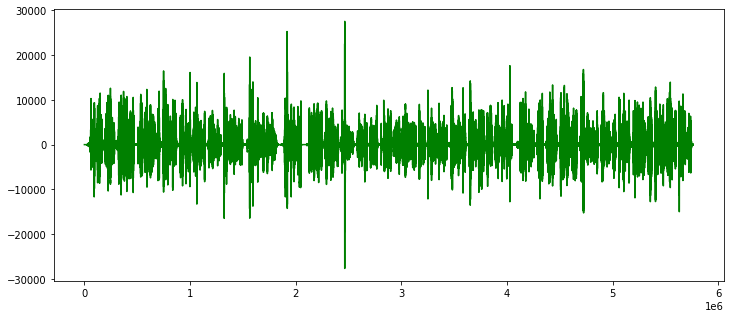

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data[:2*60*freq], c='g')
plt.show()

In [ ]:
def marking_not_to_cut(data, bound, patience, restore):
    not_to_cut = np.ones_like(data, dtype=np.bool8)
    prv = (np.abs(data) > bound).cumsum()
    prv_to_cut = np.where(prv[:-patience] == prv[patience:])
    groups = np.split(prv_to_cut[0], np.where(np.diff(prv_to_cut[0]) != 1)[0] + 1)
    to_cut = np.concatenate([np.arange(x[0] + restore, x[-1] + patience - 1) for x in groups])
    not_to_cut[to_cut] = False
    return not_to_cut

In [ ]:
bound = 2500
dur = 2*60*freq

s = time()
marked = marking_not_to_cut(data[:dur], bound, 24000, 2400)
print("time elapsed:", round(time() - s, 4))

time elapsed: 0.0806


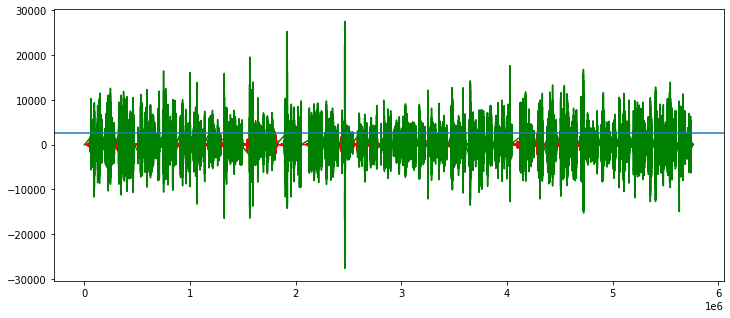

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(np.where(~marked)[0], data[:dur][~marked], c='r')
plt.plot(np.where(marked)[0], data[:dur][marked], c='g')
plt.axhline(bound)
plt.show()

In [ ]:
trunc_rate = 1 - marked.sum() / marked.shape[0]
trunc_rate

0.22829184027777782

In [ ]:
def find_bound(data, patience, restore, target_rate=.25):
  lt, rt = np.abs(data).min(), np.abs(data).max()
  total = data.shape[0]
  s = time()
  while lt + 1 < rt:
    md = (lt+rt)/2
    marked = marking_not_to_cut(data, md, patience, restore)
    if target_rate < (1 - marked.sum() / total):
      rt = md
    else:
      lt = md
  print("time elapsed:", round(time() - s, 4))
  return lt

In [ ]:
bound = find_bound(data[:2*60*freq], 24000, 2400, target_rate=.25)
bound

time elapsed: 1.6766


2941.9754638671875

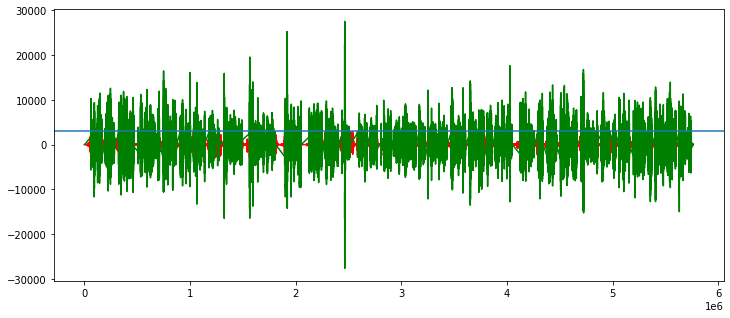

In [ ]:
dur = 2*60*freq
marked = marking_not_to_cut(data[:dur], bound, 24000, 2400)

plt.figure(figsize=(12, 5))
plt.plot(np.where(~marked)[0], data[:dur][~marked], c='r')
plt.plot(np.where(marked)[0], data[:dur][marked], c='g')
plt.axhline(bound)
plt.show()

In [ ]:
trunc_rate = 1 - marked.sum() / marked.shape[0]
trunc_rate

0.24996267361111113

In [ ]:
bound = find_bound(data[:2*60*freq], 24000, 2400, target_rate=.50)
bound

time elapsed: 1.603


4956.2401123046875

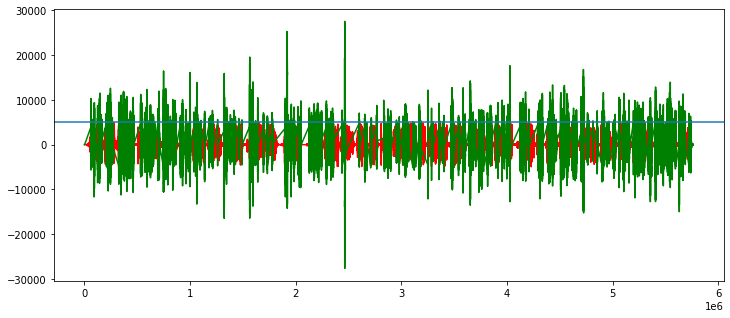

In [ ]:
dur = 2*60*freq
marked = marking_not_to_cut(data[:dur], bound, 24000, 2400)

plt.figure(figsize=(12, 5))
plt.plot(np.where(~marked)[0], data[:dur][~marked], c='r')
plt.plot(np.where(marked)[0], data[:dur][marked], c='g')
plt.axhline(bound)
plt.show()

In [ ]:
bound = find_bound(data, 24000, 2400, target_rate=.2)
print("bound:", bound)
marked = marking_not_to_cut(data, bound, 24000, 2400)

trunc_rate = 1 - marked.sum() / marked.shape[0]
print("trunc rate:", trunc_rate)

time elapsed: 20.4061
bound: 1635.7451171875
trunc rate: 0.19948567317625565


In [ ]:
idx = np.where(marked == True)[0]
groups = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)
each_dur = [len(x) for x in groups]
min(each_dur) / freq, max(each_dur) / freq

(4.1666666666666665e-05, 13.643875)

In [ ]:
len(groups)

521

In [ ]:
tmp = 0
pos = []
for i, v in enumerate(each_dur):
  if tmp + v > freq * 60:
    tmp = v
    pos.append(i - 1)
  else:
    tmp += v
len(pos)

27

In [ ]:
sum_dur = np.array(each_dur).cumsum()
pos = np.array(pos)

sum_dur[pos] / freq

array([  59.5351875 ,  117.82520833,  177.5288125 ,  233.077875  ,
        289.33802083,  341.12047917,  400.6848125 ,  460.43195833,
        519.1938125 ,  575.67829167,  633.88502083,  687.27620833,
        746.18072917,  806.0303125 ,  864.43079167,  918.7509375 ,
        975.126125  , 1029.5258125 , 1088.35010417, 1146.7466875 ,
       1204.69204167, 1262.69083333, 1321.03879167, 1380.20933333,
       1438.39375   , 1496.3218125 , 1545.9115    ])

In [ ]:
import speech_recognition as sr

In [ ]:
def to_text(fname, language="en-US", adjust_for_noise=True, offset=0, duration=60):
    r = sr.Recognizer()
    data = sr.AudioFile(fname)

    with data as source:
        if adjust_for_noise:
            r.adjust_for_ambient_noise(source)
        audio = r.record(source, offset=offset, duration=duration)

    text = r.recognize_google(audio, language=language)

    return text

In [ ]:
trunc_data = data[marked]
time_stamp = sum_dur[pos]

time_stamp

array([ 2857689,  5655610,  8521383, 11187738, 13888225, 16373783,
       19232871, 22100734, 24921303, 27632558, 30426481, 32989258,
       35816675, 38689455, 41492678, 44100045, 46806054, 49417239,
       52240805, 55043841, 57825218, 60609160, 63409862, 66250048,
       69042900, 71823447, 74203752])

In [ ]:
txt = ""
for i, v in tqdm(enumerate(range(len(time_stamp) + 1))):
  if 0 < i and i < len(time_stamp):
    target = trunc_data[time_stamp[i-1]:time_stamp[i]]
  elif i == 0:
    target = trunc_data[:time_stamp[i]]
  else:
    target = trunc_data[time_stamp[i-1]:]
  wavfile.write('./data/tmp.wav', freq, target)
  txt += " " + to_text(f"./data/tmp.wav", language="ko-KR", adjust_for_noise=False)

os.remove("./data/tmp.wav")
txt

28it [03:25,  7.32s/it]


' 아침에 해당하는 인공신경망에 대해서 알아보도록 하겠습니다 이름 자체로 저희가 런닝 부리네요 이건 이제 비선형 분류기를 설계한다는 개념을 이렇게 그런 거고요 우린 지금까지 리니어 컴비네이션 한 번 수행하는 선영이 함수에 대해서 받았지만 지금 이제 히든을 한 구조를 가짐으로써 내리냐 컴비네이션 중첩해서 쌓기 되고 있어 이걸 통해서 비선형성을 파악한다라고 보시면 되겠습니다 말을 굉장히 어려 보인데요 실제로 보면 굉장히 춥습니다 같이 보도록 하겠습니다 신경 많이 써야 돼서 이제 시작 할 거고요 구조에서 나왔다고 말을 합니다 위에 있는 일원에서 아래 있는 신경세포로 이제 신경 데이터들이 쪽 나오겠죠 그러면 그 모든게 반대쪽으로 전달될때 받는 사람 입장에서 신호를 그대로 받아들이는게 아니라 증폭을 하기도 하고 밤새 레시피 기도하고 영어로 급해서 없애주기도 합니다 무관하다면 그 신호 받을 수가 없겠다 그런 다음에 여기서 도착 했을 경우에 그 형도 답해 어떤 역치를 넘느냐 혹은 넘지못한 야로 신호에 전달이 활성화 됐느냐 그렇지 않냐를 따름이다이 과정을 우리가 축하한다 한 거 같습니다 신호들이 들어왔을 때 우리가 그것을 가중치를 부칩니다 이게 일 보다 큰 숫자 나면 우리는 증폭시킨 거고요 이게 0과 1 사이라면 우리는 감세를 찍은 거고요 예 0이라면 우리는 그 숫자를 없으신 거 없고요 있는 그대로 받아 준게 되겠죠 어쨌든 이렇게 가중치를 적용하고 다음에 그걸 다 더 하고 그것을 이제 기준치를 통해서 그 기준을 넘느냐 마느냐를 판단하는데 액티베이션 함수라고 하여 이거 얼마냐고요 시그모이드 함수로 가정한다면 그러면 기준치 0.5 되겠죠 0.5 넘으면 활성 못 넣으면 비활성 이런 관리하기 때문에 이거는 이제 불명 똑같이 생겼네 보는 것처럼 콤비네이션 하고 거기다가 뭐 바이러스 영어로 주신다면 이거를 시동은 사무실에 액티베이션 시도 뭐 3 3 이걸 가지고 이게 바로 우리의 hx8 모델이니까 0.5 다크니 아니냐로 우리가 바이너리로 1인용 이제 탄다 했으니까 어 이거 완전히 이진분

In [ ]:
def get_txt(i, trunc_data, time_stamp, result):
  if 0 < i and i < len(time_stamp):
    target = trunc_data[time_stamp[i-1]:time_stamp[i]]
  elif i == 0:
    target = trunc_data[:time_stamp[i]]
  else:
    target = trunc_data[time_stamp[i-1]:]
  wavfile.write(f"./data/tmp_{i}.wav", freq, target)
  txt = to_text(f"./data/tmp_{i}.wav", language="ko-KR", adjust_for_noise=False)
  result[i] = txt

In [ ]:
from threading import Thread

n_threads = len(time_stamp)+1
result = [None]*n_threads
threads = []

s = time()
for i in range(n_threads):
  th = Thread(target=get_txt, args=(i, trunc_data, time_stamp, result))
  threads.append(th)
  th.start()

for i, th in enumerate(threads):
  th.join()
  os.remove(f"./data/tmp_{i}.wav")

print("elapsed time:", round(time() - s, 4))

' '.join(result)

elapsed time: 15.4995


'아침에 해당하는 인공신경망에 대해서 알아보도록 하겠습니다 이름 자체로 저희가 런닝 부리네요 이건 이제 비선형 분류기를 설계한다는 개념을 이렇게 그런 거고요 우린 지금까지 리니어 컴비네이션 한 번 수행하는 선영이 함수에 대해서 받았지만 지금 이제 히든을 한 구조를 가짐으로써 내리냐 컴비네이션 중첩해서 쌓기 되고 있어 이걸 통해서 비선형성을 파악한다라고 보시면 되겠습니다 말을 굉장히 어려 보인데요 실제로 보면 굉장히 춥습니다 같이 보도록 하겠습니다 신경 많이 써야 돼서 이제 시작 할 거고요 구조에서 나왔다고 말을 합니다 위에 있는 일원에서 아래 있는 신경세포로 이제 신경 데이터들이 쪽 나오겠죠 그러면 그 모든게 반대쪽으로 전달될때 받는 사람 입장에서 신호를 그대로 받아들이는게 아니라 증폭을 하기도 하고 밤새 레시피 기도하고 영어로 급해서 없애주기도 합니다 무관하다면 그 신호 받을 수가 없겠다 그런 다음에 여기서 도착 했을 경우에 그 형도 답해 어떤 역치를 넘느냐 혹은 넘지못한 야로 신호에 전달이 활성화 됐느냐 그렇지 않냐를 따름이다이 과정을 우리가 축하한다 한 거 같습니다 신호들이 들어왔을 때 우리가 그것을 가중치를 부칩니다 이게 일 보다 큰 숫자 나면 우리는 증폭시킨 거고요 이게 0과 1 사이라면 우리는 감세를 찍은 거고요 예 0이라면 우리는 그 숫자를 없으신 거 없고요 있는 그대로 받아 준게 되겠죠 어쨌든 이렇게 가중치를 적용하고 다음에 그걸 다 더 하고 그것을 이제 기준치를 통해서 그 기준을 넘느냐 마느냐를 판단하는데 액티베이션 함수라고 하여 이거 얼마냐고요 시그모이드 함수로 가정한다면 그러면 기준치 0.5 되겠죠 0.5 넘으면 활성 못 넣으면 비활성 이런 관리하기 때문에 이거는 이제 불명 똑같이 생겼네 보는 것처럼 콤비네이션 하고 거기다가 뭐 바이러스 영어로 주신다면 이거를 시동은 사무실에 액티베이션 시도 뭐 3 3 이걸 가지고 이게 바로 우리의 hx8 모델이니까 0.5 다크니 아니냐로 우리가 바이너리로 1인용 이제 탄다 했으니까 어 이거 완전히 이진분류

In [ ]:
len(txt), len(' '.join(result))

(11115, 11118)

In [ ]:
with open("short_clean.txt", "w") as f:
  f.write(' '.join(result))